In [1]:
#note: Forestclassifier may take some time to run(or my laptop's just slow)

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RANSACRegressor


from sklearn_pandas import CategoricalImputer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, LabelBinarizer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

# make life easier
pd.set_option('display.max_rows', None)

import numpy as np
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.base import TransformerMixin

class SafeLabelBinarizer(TransformerMixin):

    def __init__(self):
        self.lb = LabelBinarizer()

    def fit(self, X):
        X = np.array(X)
        self.lb.fit(X)
        self.classes_ = self.lb.classes_

    def transform(self, X):
        K = np.append(self.classes_, ['__FAKE__'])
        X = label_binarize(X, K, pos_label=1, neg_label=0)
        X = np.delete(X, np.s_[-1], axis=1)
        return X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    

# class SafeOrdinalEncoder(TransformerMixin):

#     def __init__(self):
#         self.oe = OrdinalEncoder()

#     def fit(self, X):
#         X = np.array(X)
#         self.oe.fit(X)
#         self.classes_ = self.oe.classes_

#     def transform(self, X):
#         K = np.append(self.classes_, ['__FAKE__'])
#         X = ordinal_encode(X, K, pos_label=1, neg_label=0)
#         X = np.delete(X, np.s_[-1], axis=1)
#         return X
    
#     def fit_transform(self, X):
#         self.fit(X)
#         return self.transform(X)

In [2]:
df = pd.read_csv('data/train.csv', na_values = '', keep_default_na = False)

In [3]:
# drop outliers
df = df.drop(df[df['Gr Liv Area'] > 4000].index)

In [4]:
# drop the columns with one or two na values
df = df.dropna(subset=['Bsmt Qual','Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF','Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond'])

In [5]:
na_df = pd.DataFrame(df.isna().sum())
nz = na_df[0].to_numpy().nonzero()
na_df.iloc[nz]

,0
Lot Frontage,330
Mas Vnr Type,22
Mas Vnr Area,22
Garage Yr Blt,113


In [6]:
target = 'SalePrice'
y = df[target]
X = df.drop([target], axis = 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# mapper = DataFrameMapper([
#     ('MS SubClass', SafeLabelBinarizer()),
#     ('MS Zoning', SafeLabelBinarizer()),
#     (['Lot Frontage'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
#     (['Lot Area'], StandardScaler()),
#     ('Street', SafeLabelBinarizer()),
#     ('Alley', SafeLabelBinarizer()),
#     (['Lot Shape'], OrdinalEncoder(categories = [['Reg', 'IR1', 'IR2', 'IR3']])),
#     (['Land Contour'], OrdinalEncoder(categories = [['Lvl', 'Low', 'Bnk', 'HLS']])),
#     (['Utilities'], SafeOrdinalEncoder(categories = [[ 'NoSewr', 'AllPub']])),
#     ('Lot Config', SafeLabelBinarizer()),
#     (['Land Slope'], OrdinalEncoder(categories = [['Gtl', 'Mod', 'Sev']])),
#     ('Neighborhood', SafeLabelBinarizer()),
#     ('Condition 1', SafeLabelBinarizer()),
#     ('Condition 2', SafeLabelBinarizer()),
#     ('Bldg Type', SafeLabelBinarizer()),
#     ('House Style', SafeLabelBinarizer()),
#     (['Overall Qual'], OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])),
#     (['Overall Cond'], OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9]])),
#     (['Year Built'], None),
#     (['Year Remod/Add'], None),
#     ('Roof Style', SafeLabelBinarizer()),
#     ('Roof Matl', SafeLabelBinarizer()),
#     ('Exterior 1st', SafeLabelBinarizer()),
#     ('Exterior 2nd', SafeLabelBinarizer()),
#     (['Mas Vnr Type'], [SimpleImputer(strategy = 'constant', fill_value = 'Not_applicable'), SafeLabelBinarizer()]),
#     (['Mas Vnr Area'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
#     (['Exter Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa']])),
#     (['Exter Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po']])),
#     ('Foundation', SafeLabelBinarizer()),
#     (['Bsmt Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa','NA']])),
#     (['Bsmt Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
#     (['Bsmt Exposure'], OrdinalEncoder(categories = [['NA', 'No', 'Mn', 'Av', 'Gd']])),
#     (['BsmtFin Type 1'], OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ','GLQ']])),
#     (['BsmtFin SF 1'], StandardScaler()),
#     (['BsmtFin Type 2'], [SimpleImputer(strategy = 'constant', fill_value = 'Not_applicable'), OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ','GLQ']])]),
#     (['BsmtFin SF 2'], StandardScaler()),
#     (['Bsmt Unf SF'], StandardScaler()),
#     (['Total Bsmt SF'], StandardScaler()),
#     (['Heating'], OrdinalEncoder(categories = [['GasA', 'GasW', 'Grav', 'OthW', 'Wall']])),
#     (['Heating QC'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po']])),
#     ('Central Air', LabelEncoder()),
#     (['Electrical'], OrdinalEncoder(categories = [['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']])),
#     (['1st Flr SF'], StandardScaler()),
#     (['2nd Flr SF'], StandardScaler()),
#     (['Low Qual Fin SF'], StandardScaler()),
#     (['Gr Liv Area'], StandardScaler()),
#     ('Bsmt Full Bath', None),
#     ('Bsmt Half Bath', None),
#     ('Full Bath', None),
#     ('Half Bath', None),
#     ('Bedroom AbvGr', None),
#     ('Kitchen AbvGr', None),
#     (['Kitchen Qual'], OrdinalEncoder(categories = [['Fa', 'TA', 'Gd', 'Ex']])),
#     ('TotRms AbvGrd', None),
#     (['Functional'], OrdinalEncoder(categories = [['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sal']])),
#     ('Fireplaces', None),
#     (['Fireplace Qu'], OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])),
#     ('Garage Type', SafeLabelBinarizer()),
#     (['Garage Yr Blt'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
#     (['Garage Finish'], OrdinalEncoder(categories = [['NA', 'Unf', 'RFn', 'Fin']])),
#     ('Garage Cars', None),
#     (['Garage Area'], StandardScaler()),
#     (['Garage Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
#     (['Garage Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
#     (['Paved Drive'], OrdinalEncoder(categories = [['Y', 'P', 'N']])),
#     (['Wood Deck SF'], StandardScaler()),
#     (['Open Porch SF'], StandardScaler()),
#     (['Enclosed Porch'], StandardScaler()),
#     (['3Ssn Porch'], StandardScaler()),
#     (['Screen Porch'], StandardScaler()),
#     (['Pool Area'], StandardScaler()),
#     (['Pool QC'], OrdinalEncoder(categories = [['NA', 'Fa', 'TA', 'Gd', 'Ex']])),
#     (['Fence'], OrdinalEncoder(categories = [['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])),
#     (['Misc Feature'], SafeLabelBinarizer()),
#     (['Misc Val'], StandardScaler()),
#     ('Mo Sold', None),
#     ('Yr Sold', None),
#     ('Sale Type', SafeLabelBinarizer())], df_out = True)

In [9]:
mapper = DataFrameMapper([
    ('MS SubClass', SafeLabelBinarizer()),
    ('MS Zoning', SafeLabelBinarizer()),
    (['Lot Frontage'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
    (['Lot Area'], StandardScaler()),
    ('Street', SafeLabelBinarizer()),
    ('Alley', SafeLabelBinarizer()),
    (['Lot Shape'], OrdinalEncoder(categories = [['Reg', 'IR1', 'IR2', 'IR3']])),
    (['Land Contour'], OrdinalEncoder(categories = [['Lvl', 'Low', 'Bnk', 'HLS']])),
    (['Utilities'], SafeLabelBinarizer()),
    ('Lot Config', SafeLabelBinarizer()),
    (['Land Slope'], OrdinalEncoder(categories = [['Gtl', 'Mod', 'Sev']])),
    ('Neighborhood', SafeLabelBinarizer()),
    ('Condition 1', SafeLabelBinarizer()),
    ('Condition 2', SafeLabelBinarizer()),
    ('Bldg Type', SafeLabelBinarizer()),
    ('House Style', SafeLabelBinarizer()),
    (['Overall Qual'], OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])),
    (['Overall Cond'], OrdinalEncoder(categories = [[1, 2, 3, 4, 5, 6, 7, 8, 9]])),
    (['Year Built'], None),
    (['Year Remod/Add'], None),
    ('Roof Style', SafeLabelBinarizer()),
    ('Roof Matl', SafeLabelBinarizer()),
    ('Exterior 1st', SafeLabelBinarizer()),
    ('Exterior 2nd', SafeLabelBinarizer()),
    (['Mas Vnr Type'], [SimpleImputer(strategy = 'constant', fill_value = 'Not_applicable'), SafeLabelBinarizer()]),
    (['Mas Vnr Area'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
    (['Exter Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa']])),
    (['Exter Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po']])),
    ('Foundation', SafeLabelBinarizer()),
    (['Bsmt Qual'], SafeLabelBinarizer()),
    (['Bsmt Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
    (['Bsmt Exposure'], OrdinalEncoder(categories = [['NA', 'No', 'Mn', 'Av', 'Gd']])),
    (['BsmtFin Type 1'], OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ','GLQ']])),
    (['BsmtFin SF 1'], StandardScaler()),
    (['BsmtFin Type 2'], [SimpleImputer(strategy = 'constant', fill_value = 'Not_applicable'), OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ','GLQ']])]),
    (['BsmtFin SF 2'], StandardScaler()),
    (['Bsmt Unf SF'], StandardScaler()),
    (['Total Bsmt SF'], StandardScaler()),
    (['Heating'], OrdinalEncoder(categories = [['GasA', 'GasW', 'Grav', 'OthW', 'Wall']])),
    (['Heating QC'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po']])),
    ('Central Air', LabelEncoder()),
    (['Electrical'], OrdinalEncoder(categories = [['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']])),
    (['1st Flr SF'], StandardScaler()),
    (['2nd Flr SF'], StandardScaler()),
    (['Low Qual Fin SF'], StandardScaler()),
    (['Gr Liv Area'], StandardScaler()),
    ('Bsmt Full Bath', None),
    ('Bsmt Half Bath', None),
    ('Full Bath', None),
    ('Half Bath', None),
    ('Bedroom AbvGr', None),
    ('Kitchen AbvGr', None),
    (['Kitchen Qual'], OrdinalEncoder(categories = [['Fa', 'TA', 'Gd', 'Ex']])),
    ('TotRms AbvGrd', None),
    (['Functional'], SafeLabelBinarizer()),
    ('Fireplaces', None),
    (['Fireplace Qu'], OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])),
    ('Garage Type', SafeLabelBinarizer()),
    (['Garage Yr Blt'], [SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler()]),
    (['Garage Finish'], OrdinalEncoder(categories = [['NA', 'Unf', 'RFn', 'Fin']])),
    ('Garage Cars', None),
    (['Garage Area'], StandardScaler()),
    (['Garage Qual'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
    (['Garage Cond'], OrdinalEncoder(categories = [['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']])),
    (['Paved Drive'], OrdinalEncoder(categories = [['Y', 'P', 'N']])),
    (['Wood Deck SF'], StandardScaler()),
    (['Open Porch SF'], StandardScaler()),
    (['Enclosed Porch'], StandardScaler()),
    (['3Ssn Porch'], StandardScaler()),
    (['Screen Porch'], StandardScaler()),
    (['Pool Area'], StandardScaler()),
    (['Pool QC'], OrdinalEncoder(categories = [['NA', 'Fa', 'TA', 'Gd', 'Ex']])),
    (['Fence'], OrdinalEncoder(categories = [['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']])),
    (['Misc Feature'], SafeLabelBinarizer()),
    (['Misc Val'], StandardScaler()),
    ('Mo Sold', None),
    ('Yr Sold', None),
    ('Sale Type', SafeLabelBinarizer())], df_out = True)

In [10]:
# naive model
# house price goes up by how many rooms are there in the house
linreg = LinearRegression()
linreg.fit(X_train[['Bedroom AbvGr']], y_train)
linreg.score(X_test[['Bedroom AbvGr']], y_test)

0.007158416954324398

In [11]:
Z_train = mapper.fit_transform(X_train)

/home/anika/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
# exploratory data analysis

continuous = ['Lot Frontage', 'Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

In [13]:
# for feature in continuous:
#     plt.figure(figsize = (10,5))
#     plt.scatter(Z_train[feature], y_train)
#     plt.title(feature)
#     plt.show()

# picked out Lot frontage, lot area, year built(log?), total bsmt SF, gr living area, garage area,

In [14]:
# feature selection using ANOVA
from sklearn.feature_selection import SelectPercentile

select = SelectPercentile(percentile=5)
select.fit(Z_train, y_train)
Z_train_selected = select.transform(Z_train)

# find selected features and put it in a column
selection = select.get_support()
select_df = pd.DataFrame(zip(Z_train.columns.ravel(), selection), columns = ['feature', 'bool'])
select_df[select_df['bool']]

/home/anika/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  19
  32  33  82 118 153 189 217 225] are constant.
  UserWarning)
/home/anika/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/anika/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,feature,bool
16,MS Zoning_A (agr),True
19,MS Zoning_I (all),True
32,Utilities_AllPub,True
33,Utilities_NoSewr,True
82,Condition 2_RRAn,True
97,Overall Qual,True
118,Exterior 1st_ImStucc,True
153,Foundation_Stone,True
189,Functional_Sal,True
217,Misc Feature_Othr,True


In [15]:
linreg = LinearRegression()
linreg.fit(Z_train, y_train)
linreg.score(Z_train, y_train)

0.9398796262007573

In [16]:
linreg.fit(Z_train_selected, y_train)
linreg.score(Z_train_selected, y_train)

0.6583897883106334

In [17]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=10, random_state=42), n_features_to_select=10)
select.fit(Z_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=42,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

In [18]:
Z_train_selected = select.transform(Z_train)

# find selected features and put it in a column
selection = select.get_support()
select_df = pd.DataFrame(zip(Z_train.columns.ravel(), selection), columns = ['feature', 'bool'])
select_df[select_df['bool']]

,feature,bool
24,Lot Area,True
99,Year Built,True
163,BsmtFin SF 1,True
166,Bsmt Unf SF,True
167,Total Bsmt SF,True
172,1st Flr SF,True
175,Gr Liv Area,True
200,Garage Yr Blt,True
203,Garage Area,True
221,Mo Sold,True


In [19]:
linreg.fit(Z_train, y_train)
linreg.score(Z_train, y_train)

0.9398796262007573

In [20]:
linreg.fit(Z_train_selected, y_train)
linreg.score(Z_train_selected, y_train)

0.8041537657575873

In [21]:
# let's try out different models on this now
# linear regression
Z_test = mapper.transform(X_test)

/home/anika/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [22]:
select_df = select_df[select_df['bool']]
select_df

,feature,bool
24,Lot Area,True
99,Year Built,True
163,BsmtFin SF 1,True
166,Bsmt Unf SF,True
167,Total Bsmt SF,True
172,1st Flr SF,True
175,Gr Liv Area,True
200,Garage Yr Blt,True
203,Garage Area,True
221,Mo Sold,True


forestclassifier is picking up most of the correlated features from the scatterplots and showing higher model performance, so we're kepping forest classifier as the feature selection method

In [23]:
Z_test_selected = select.transform(Z_test)

In [24]:
linreg.score(Z_test_selected, y_test)

0.7651915663876085

In [25]:
lassomodel = Lasso()
lassomodel.fit(Z_train_selected, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
lassomodel.score(Z_train_selected, y_train)

0.8041537609180501

In [27]:
lassomodel.score(Z_test_selected, y_test)

0.7651994737908446

In [28]:
ridgemodel = Ridge()

In [29]:
ridgemodel.fit(Z_train_selected, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
ridgemodel.score(Z_test_selected, y_test)

0.7652477459582505

In [31]:
rsmodel = RANSACRegressor()

In [32]:
rsmodel.fit(Z_train_selected, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=None, random_state=None, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [33]:
rsmodel.score(Z_test_selected, y_test)

0.5645214031795711

In [34]:
linreg_pred = linreg.predict(Z_test_selected)
lasso_pred = lassomodel.predict(Z_test_selected)
ridge_pred = ridgemodel.predict(Z_test_selected)
rs_pred = rsmodel.predict(Z_test_selected)
metrics_df = pd.DataFrame([
    ('linreg', r2_score(linreg_pred, y_test), mean_squared_error(linreg_pred, y_test), mean_absolute_error(linreg_pred, y_test)),
    ('lasso', r2_score(lasso_pred, y_test), mean_squared_error(lasso_pred, y_test), mean_absolute_error(lasso_pred, y_test)),
    ('ridge', r2_score(ridge_pred, y_test), mean_squared_error(ridge_pred, y_test), mean_absolute_error(ridge_pred, y_test)),
    ('RANSAC', r2_score(rs_pred, y_test), mean_squared_error(rs_pred, y_test), mean_absolute_error(rs_pred, y_test))
], columns = ['score', 'r2 score', 'mean squared error', 'mean absolute error'])

In [35]:
metrics_df

,score,r2 score,mean squared error,mean absolute error
0,linreg,0.695536,1.529074e+09,26749.600252
1,lasso,0.695534,1.529023e+09,26748.818246
2,ridge,0.695444,1.528708e+09,26742.650040
3,RANSAC,0.436113,2.835840e+09,35473.477337


In [36]:
# since model is not doing well, we're gonna try to lasso out some of the stuff

In [37]:
l_alphas = np.linspace(0.1, 1, 85)
lasso_model = LassoCV(alphas=l_alphas, cv=5)
lasso_model = lasso_model.fit(Z_train_selected, y_train)
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

1.0

In [38]:
select_df.feature.ravel()

array(['Lot Area', 'Year Built', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Yr Blt',
       'Garage Area', 'Mo Sold'], dtype=object)

In [39]:
Z_lasso_coef = pd.DataFrame(zip(lassomodel.coef_, select_df.feature.ravel()))

In [40]:
Z_lasso_coef

,0,1
0,5060.269489,Lot Area
1,635.579612,Year Built
2,9553.478567,BsmtFin SF 1
3,-1991.960051,Bsmt Unf SF
4,20442.999296,Total Bsmt SF
5,-1722.486127,1st Flr SF
6,36666.285471,Gr Liv Area
7,-2458.154354,Garage Yr Blt
8,12156.696022,Garage Area
9,506.328922,Mo Sold


In [41]:
Z_train_selected = pd.DataFrame(Z_train_selected, columns = select_df.feature.ravel())
Z_train_selected.head()

,Lot Area,Year Built,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,Gr Liv Area,Garage Yr Blt,Garage Area,Mo Sold
0,-0.917166,1900.0,-0.992532,-0.068764,-1.212943,-0.708567,-0.106454,0.157048,-0.557942,4.0
1,0.369252,1995.0,-0.992532,1.507911,0.444550,0.246370,2.086382,0.278264,1.289663,6.0
2,-0.007446,1940.0,-0.992532,0.465778,-0.651001,-0.563480,-0.005182,0.157048,-1.076568,7.0
3,-0.515776,2003.0,-0.992532,0.506206,-0.608501,-0.927516,0.480507,0.295896,0.664533,5.0
4,0.913413,2002.0,2.518790,-0.742557,1.710100,1.657670,0.608646,0.293692,1.122961,6.0


In [42]:
Z_train_lasso = Z_train_selected[['Total Bsmt SF', 'Gr Liv Area', 'Garage Area']]

In [43]:
Z_test_selected= pd.DataFrame(Z_test_selected, columns = select_df.feature.ravel())

In [44]:
Z_test_lasso = Z_test_selected[['Total Bsmt SF', 'Gr Liv Area', 'Garage Area']]

In [45]:
linreg.fit(Z_train_lasso, y_train)
lassomodel.fit(Z_train_lasso, y_train)
ridgemodel.fit(Z_train_lasso, y_train)
rsmodel.fit(Z_train_lasso, y_train)


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=None, random_state=None, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [46]:
linreg_pred2 = linreg.predict(Z_test_lasso)
lasso_pred2 = lassomodel.predict(Z_test_lasso)
ridge_pred2 = ridgemodel.predict(Z_test_lasso)
rs_pred2 = rsmodel.predict(Z_test_lasso)
metrics_df2 = pd.DataFrame([
    ('linreg', r2_score(linreg_pred2, y_test), mean_squared_error(linreg_pred2, y_test), mean_absolute_error(linreg_pred2, y_test)),
    ('lasso', r2_score(lasso_pred2, y_test), mean_squared_error(lasso_pred2, y_test), mean_absolute_error(lasso_pred2, y_test)),
    ('ridge', r2_score(ridge_pred2, y_test), mean_squared_error(ridge_pred2, y_test), mean_absolute_error(ridge_pred2, y_test)),
    ('RANSAC', r2_score(rs_pred2, y_test), mean_squared_error(rs_pred2, y_test), mean_absolute_error(rs_pred2, y_test))
], columns = ['score', 'r2 score', 'mean squared error', 'mean absolute error'])

In [47]:
metrics_df2

,score,r2 score,mean squared error,mean absolute error
0,linreg,0.583962,1.905166e+09,30226.037290
1,lasso,0.583946,1.905168e+09,30225.931649
2,ridge,0.583685,1.905053e+09,30222.842035
3,RANSAC,0.210367,2.286286e+09,31925.660270


In [48]:
# lasso cant save me, so we keep the featured selected set

In [49]:
#this chunk takes about 5 minutes to run

# make a pipeline for new data
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(mapper, select, lassomodel)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

/home/anika/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/anika/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


0.7651994737908446

Housing prices can be predicted with 76% accuracy through this model where MS Zoning_A, MS Zoning_I (all), Utilities_AllPub, Utilities_NoSewr, Condition 2_RRAn, Overall Qual, Exterior 1st_ImStucc, Foundation_Stone, Functional_Sal, Misc Feature_Othr, Sale Type_Con and Sale Type_New columns are taken into consideration.

- Agricultural zones, 
- industrial zones, 
- all public utilities(electricity, gas, water), 
- proximity to north-south railroad, 
- overall quality, 
- imitation stucco on the exterior, 
- stone foundation, 
- salavge only properties, 
- miscellenious features, 
- 15% down payment contract payment option on sale or 
- just contracted homes 

are the factors affecting sale prices in this dataset.

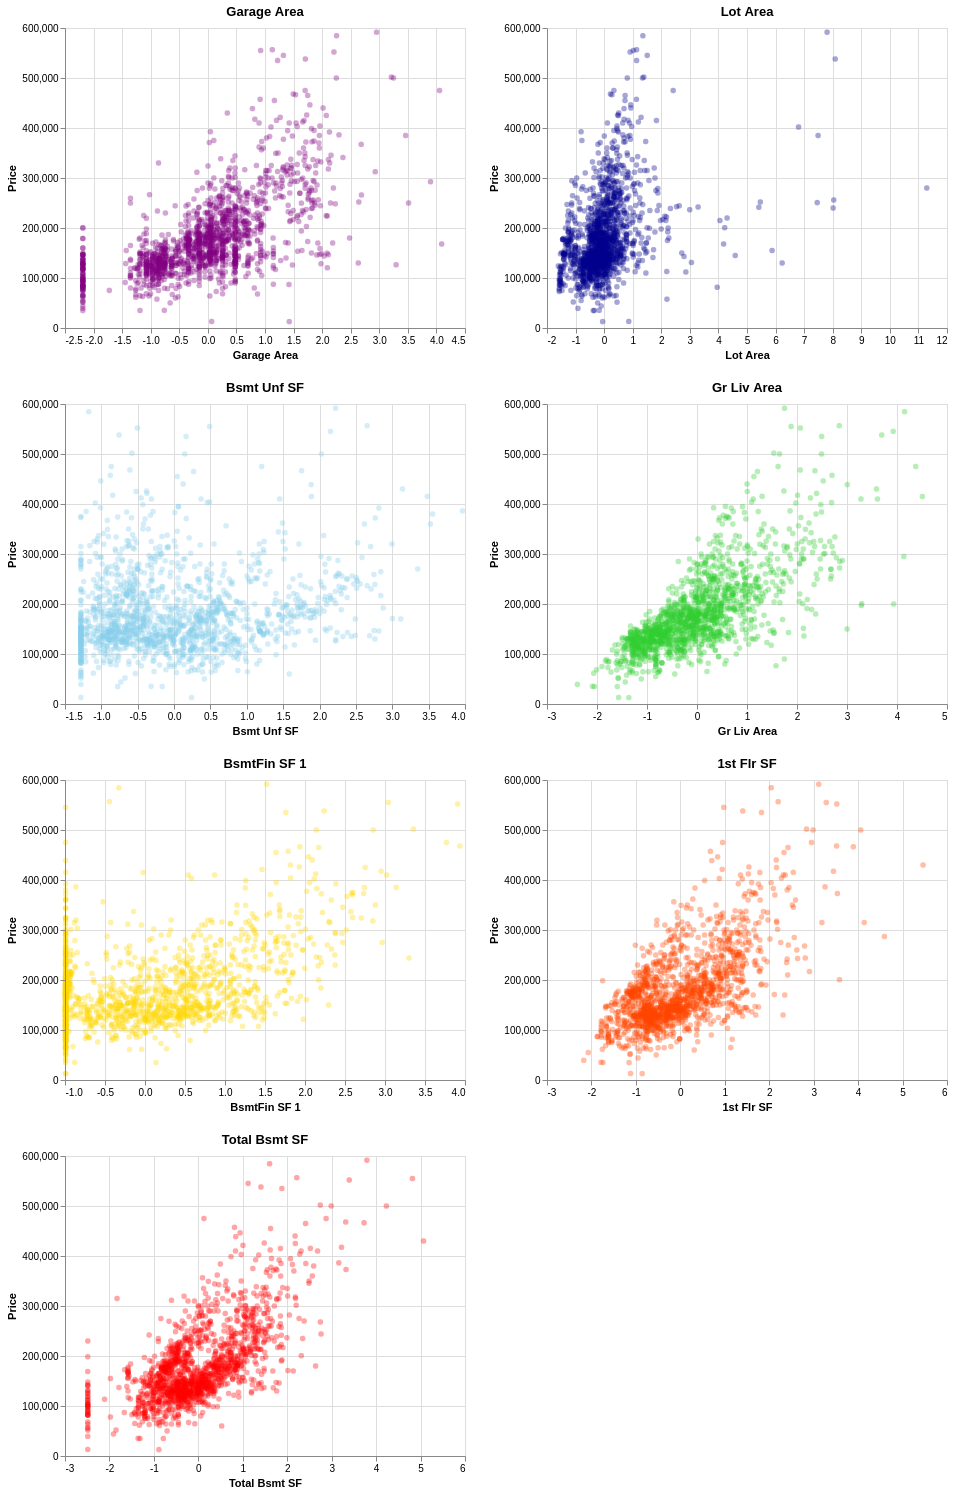

In [50]:
alt.renderers.enable('notebook')
final_feature_df = select_df[select_df['bool']]
final_features = list(set(final_feature_df.feature.tolist()) - {'Garage Yr Blt', 'Mo Sold'})
alt_df = pd.DataFrame(Z_train_selected, columns = final_feature_df.feature.tolist())
alt_df['y'] = 0
alt_df['y'] = y_train.values
charts = []
colors = ['purple', 'darkblue', 'skyblue', 'limegreen', 'gold', 'orangered', 'red', 'pink']
i = 0
for feature in final_features:
    c = alt.Chart(alt_df).mark_circle(color = colors[i], fillOpacity = 0.5).encode(alt.X(feature, title = feature), alt.Y('y', title = 'Price')).properties(title=feature)
    charts.append(c)
    i += 1
set_1 = charts[0] | charts[1] 
set_2 = charts[2] | charts[3]
set_3 = charts[4] | charts[5] 
set_4 = charts[6]
alt.vconcat(set_1, set_2, set_3, set_4)